# DGMD E-14
## PSET12 - EXTRA CREDIT

Note: This section is optional extra credit for all credit status (undergraduates and graduate students). This section is intended for students looking for more depth or advanced material. This section may require additional self-study to complete. Since this is extra credit, assistance from Gradescope will be limited. Furthermore, there will be limited support from course staff, office hours, and Ed discussion.

So far, you've been building neural networks prescriptively based on the specifications. For extra credit, design your own custom neural network. You are free to leverage any pre-trained models, implement custom architectures, and set hyperparameters. You are also free to use either TensorFlow or PyTorch (either will suffice) and any pre-trained model(s).

If your model achieves at least 94% accuracy on the validation set, you'll get 10 extra credit points. If your model achieves at least 97% accuracy on the validation set, you'll get 20 extra credit points.

In terms of work and submission, please do this in a separate notebook altogether. Once you've designed a neural network that acheives the minimum validation accuracy, please email your notebook submission to the course staff at harvard.dgmd14@gmail.com.

The reason for a separate notebook is because this section is very open-ended (i.e., many ways of doing it) and course staff will grade it separately.

In terms of the data, the dataset for this problem set is an open source dataset, called tf_flowers. You can either download / access it in which ever method you find most convenient from online or you can copy the code in the Context & Data Preparation section which downloads it for you.

In terms of grading, the course staff will review and execute your notebook with the validation set - please make check that the code runs with no errors (so explicitly disconnect your runtime and re-run everything to make sure it works). Additionally, label or clearly document which section is the final model versus your experiments / prototypes.

In [1]:
# importing the libraries
import numpy as np
import tensorflow as tf

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


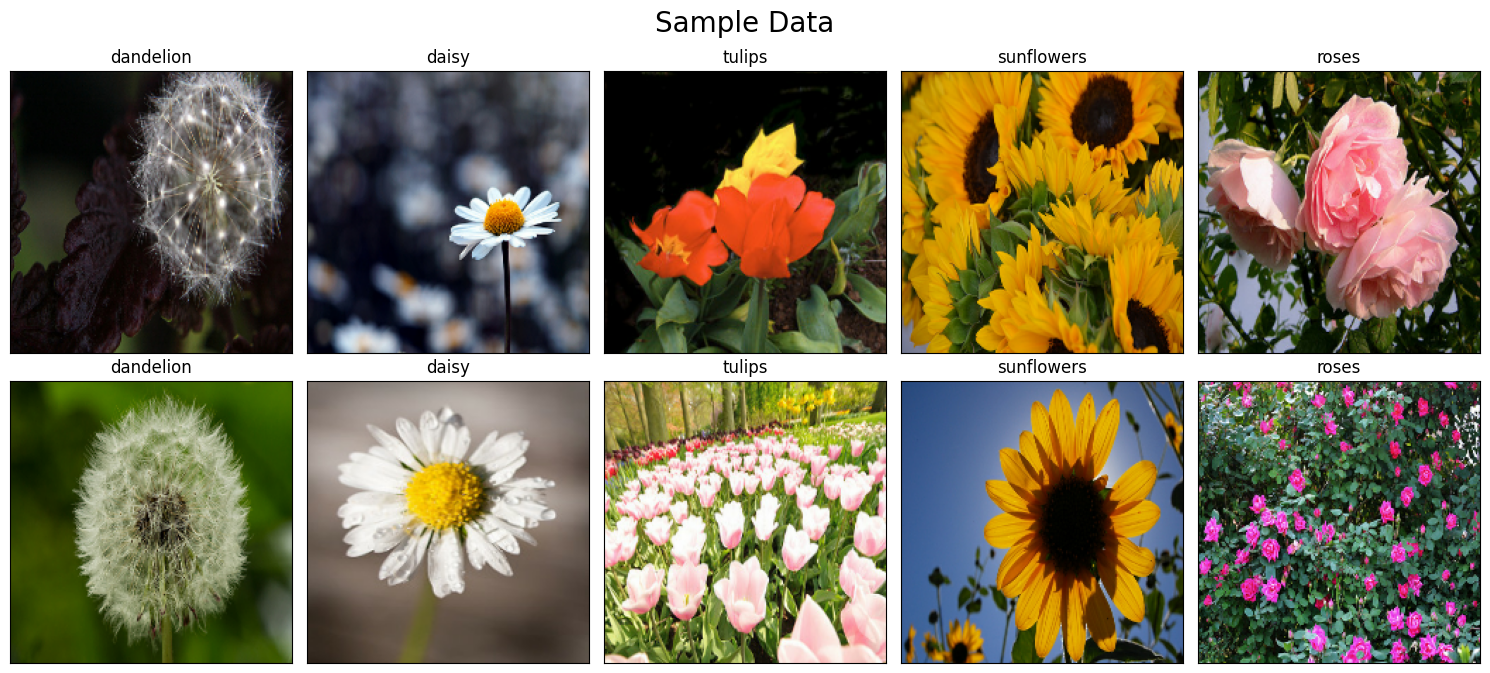

In [2]:
#@title Data Loading & Overview
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# define constants
SEED: int = 1636
IMAGE_DIM: int = 200
BATCH_SIZE: int = 32

# set random seed to handle stochasticity
tf.random.set_seed(SEED)

# download and extract dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, untar=True)

# convert to pathlib.Path and point to the photos directory
data_dir = pathlib.Path(data_dir) / "flower_photos"

# load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMAGE_DIM, IMAGE_DIM),
    batch_size=BATCH_SIZE
)

# load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMAGE_DIM, IMAGE_DIM),
    batch_size=BATCH_SIZE
)

# get class names
class_names: list[str] = train_ds.class_names

# dictionary to store sample images for each category
category_images: dict[str, list[np.ndarray]] = {class_name: [] for class_name in class_names}

# loop through the training dataset and collect images for each category
for images, labels in train_ds:
    # convert images and tensors to numpy arrays
    images: np.ndarray = images.numpy().astype("uint8")
    labels: np.ndarray = labels.numpy()

    for class_name in class_names:
        # get numeric label
        class_label = class_names.index(class_name)

        # get indices of this class
        indices = np.where(labels == class_label)[0]

        # store images in dictionary
        category_images[class_name].extend([images[i] for i in indices])

# display 10 images, 2 of each category, in grid of 2 rows and 5 columns
sample_images: list[list[tuple[np.ndarray, str]]] = [
    [
        (category_images["dandelion"][0], "dandelion"),
        (category_images["daisy"][4], "daisy"),
        (category_images["tulips"][0], "tulips"),
        (category_images["sunflowers"][10], "sunflowers"),
        (category_images["roses"][0], "roses")
    ],
    [
        (category_images["dandelion"][1], "dandelion"),
        (category_images["daisy"][1], "daisy"),
        (category_images["tulips"][1], "tulips"),
        (category_images["sunflowers"][4], "sunflowers"),
        (category_images["roses"][6], "roses")
    ],
]

fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 7))
fig.suptitle(f"Sample Data", fontsize=20)
for r, row in enumerate(axes):
    for c, _ in enumerate(row):
        ax = axes[r, c]
        img = sample_images[r][c][0]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
        ax.set_title(f"{sample_images[r][c][1]}")

plt.tight_layout()

In [4]:
#@title Model Design & Training

# Optimizing Data Performance
# We use caching and prefetching to stop I/O blocking
AUTOTUNE = tf.data.AUTOTUNE

# Apply optimization to training and validation sets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation Layer
# This adds random variations to images only during training
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
    tf.keras.layers.RandomRotation(0.2, seed=SEED),
    tf.keras.layers.RandomZoom(0.2, seed=SEED),
    tf.keras.layers.RandomContrast(0.2, seed=SEED),
])

# Building the Model. We will utilize transfer learning
# We will use EfficientNetV2B3
# We use B3 as it offers a great balance of depth and resolution handling
# Input shape matches our constant: (200, 200, 3)

base_model = tf.keras.applications.EfficientNetV2B3(
    input_shape=(IMAGE_DIM, IMAGE_DIM, 3),
    include_top=False, # Drop the ImageNet classification head
    weights='imagenet'
)

# CRITICAL STEP FOR BEST ACCURACY:
# We unfreeze the base model to allow fine-tuning of the weights.
base_model.trainable = True

# Constructing the final architecture
inputs = tf.keras.Input(shape=(IMAGE_DIM, IMAGE_DIM, 3))
x = data_augmentation(inputs)  # Apply augmentation
x = tf.keras.applications.efficientnet_v2.preprocess_input(x) # Scale pixel values
x = base_model(x, training=True) # Pass through EfficientNet
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Flatten results
x = tf.keras.layers.Dropout(0.4)(x) # Reduce overfitting
outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # 5 Flower classes

model = tf.keras.Model(inputs, outputs)

# Compiling the Model
# We use a lower learning rate (1e-4) because the model is already
# pretrained. High LR would destroy the pretrained weights.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

# Callbacks for Optimal Training
callbacks = [
    # Stop if validation loss doesn't improve for 10 epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    # Reduce Learning Rate if accuracy plateaus
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
]

# Training
# ------------------------------------------
# Training for 20 epochs is usually sufficient to hit the target
# EarlyStopping will cut it short if it converges faster.
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=callbacks
)

# Final Evaluation
loss, accuracy = model.evaluate(val_ds)
print(f"Final Validation Accuracy: {accuracy*100:.2f}%")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 7, 7, 1536)     │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         7,685 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,307 (49.36 MB)

 Trainable params: 12,829,091 (48.94 MB)

 Non-trainable params: 109,216 (426.62 KB)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 207ms/step - accuracy: 0.5189 - loss: 1.2156 - val_accuracy: 0.8910 - val_loss: 0.3823 - learning_rate: 1.0000e-04
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.8567 - loss: 0.4160 - val_accuracy: 0.9237 - val_loss: 0.2293 - learning_rate: 1.0000e-04
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.9173 - loss: 0.2571 - val_accuracy: 0.9292 - val_loss: 0.2038 - learning_rate: 1.0000e-04
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9416 - loss: 0.1681 - val_accuracy: 0.9373 - val_loss: 0.1883 - learning_rate: 1.0000e-04
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9575 - loss: 0.1230 - val_accuracy: 0.9346 - val_loss: 0.1860 - learning_rate: 1.0000e-04
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.9703 - loss: 0.0906 - val_accuracy: 0.9319 - val_loss: 0.2066 - learning_rate: 1.0000e-04
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - acc

We got 95.23%. This is good. Nevertheless, I think we can improve upon this. Let's try a different architecture.

I will bump up the image size. I will also use ConvNeXtBase instead of EfficientNetV2B3. Let' see what we get.

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


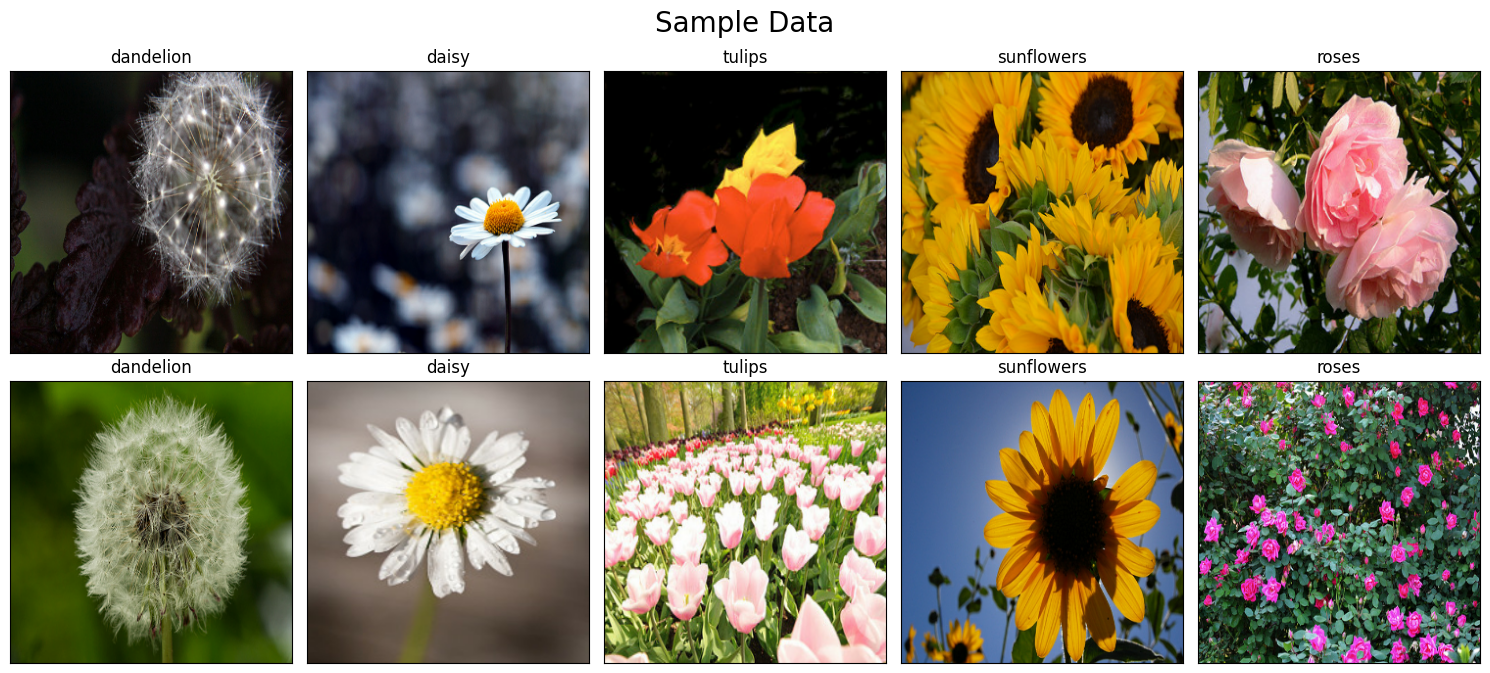

In [7]:
#@title Data Loading & Overview. Second Attempt.
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# define constants
SEED: int = 1636
IMAGE_DIM: int = 288
BATCH_SIZE: int = 32

# set random seed to handle stochasticity
tf.random.set_seed(SEED)

# download and extract dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, untar=True)

# convert to pathlib.Path and point to the photos directory
data_dir = pathlib.Path(data_dir) / "flower_photos"

# load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMAGE_DIM, IMAGE_DIM),
    batch_size=BATCH_SIZE
)

# load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMAGE_DIM, IMAGE_DIM),
    batch_size=BATCH_SIZE
)

# get class names
class_names: list[str] = train_ds.class_names

# dictionary to store sample images for each category
category_images: dict[str, list[np.ndarray]] = {class_name: [] for class_name in class_names}

# loop through the training dataset and collect images for each category
for images, labels in train_ds:
    # convert images and tensors to numpy arrays
    images: np.ndarray = images.numpy().astype("uint8")
    labels: np.ndarray = labels.numpy()

    for class_name in class_names:
        # get numeric label
        class_label = class_names.index(class_name)

        # get indices of this class
        indices = np.where(labels == class_label)[0]

        # store images in dictionary
        category_images[class_name].extend([images[i] for i in indices])

# display 10 images, 2 of each category, in grid of 2 rows and 5 columns
sample_images: list[list[tuple[np.ndarray, str]]] = [
    [
        (category_images["dandelion"][0], "dandelion"),
        (category_images["daisy"][4], "daisy"),
        (category_images["tulips"][0], "tulips"),
        (category_images["sunflowers"][10], "sunflowers"),
        (category_images["roses"][0], "roses")
    ],
    [
        (category_images["dandelion"][1], "dandelion"),
        (category_images["daisy"][1], "daisy"),
        (category_images["tulips"][1], "tulips"),
        (category_images["sunflowers"][4], "sunflowers"),
        (category_images["roses"][6], "roses")
    ],
]

fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 7))
fig.suptitle(f"Sample Data", fontsize=20)
for r, row in enumerate(axes):
    for c, _ in enumerate(row):
        ax = axes[r, c]
        img = sample_images[r][c][0]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
        ax.set_title(f"{sample_images[r][c][1]}")

plt.tight_layout()

In [10]:
#@title Model Design & Training. Second Attempt. BEST MODEL.

# Optimizing Data Performance
# We use caching and prefetching to stop I/O blocking
AUTOTUNE = tf.data.AUTOTUNE

# Apply optimization to training and validation sets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation Layer
# This adds random variations to images only during training
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
    tf.keras.layers.RandomRotation(0.2, seed=SEED),
    tf.keras.layers.RandomZoom(0.2, seed=SEED),
    tf.keras.layers.RandomContrast(0.2, seed=SEED),
])

# Building the Model. We will utilize transfer learning
# We will use EfficientNetV2B3
# We use B3 as it offers a great balance of depth and resolution handling
# Input shape matches our constant: (IMAGE_DIM, IMAGE_DIM, 3)

base_model = tf.keras.applications.ConvNeXtBase(
    input_shape=(IMAGE_DIM, IMAGE_DIM, 3),
    include_top=False,
    weights='imagenet'
)

# CRITICAL STEP FOR BEST ACCURACY:
# We unfreeze the base model to allow fine-tuning of the weights.
base_model.trainable = True

# Constructing the final architecture
inputs = tf.keras.Input(shape=(IMAGE_DIM, IMAGE_DIM, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.convnext.preprocess_input(x)
x = base_model(x, training=False)  # note: training=False for BatchNorm during aug
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)  # helps a lot!
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Compiling the Model
# We use a lower learning rate (1e-4) because the model is already
# pretrained. High LR would destroy the pretrained weights.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

# Callbacks for Optimal Training
callbacks = [
    # Stop if validation loss doesn't improve for 4 epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    ),
    # Reduce Learning Rate if accuracy plateaus
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
]

# Training
# ------------------------------------------
# Training for 20 epochs is usually sufficient to hit the target
# EarlyStopping will cut it short if it converges faster.
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=callbacks
)

# Final Evaluation
loss, accuracy = model.evaluate(val_ds)
print(f"Final Validation Accuracy: {accuracy*100:.2f}%")

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 288, 288, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 288, 288, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 9, 9, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,575,685 (334.07 MB)

 Trainable params: 87,573,637 (334.07 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.8275 - loss: 0.5004 - val_accuracy: 0.9537 - val_loss: 0.1534 - learning_rate: 1.0000e-04
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 734ms/step - accuracy: 0.9661 - loss: 0.1138 - val_accuracy: 0.9741 - val_loss: 0.0714 - learning_rate: 1.0000e-04
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 735ms/step - accuracy: 0.9795 - loss: 0.0619 - val_accuracy: 0.9782 - val_loss: 0.0580 - learning_rate: 1.0000e-04
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 67s 732ms/step - accuracy: 0.9965 - loss: 0.0146 - val_accuracy: 0.9768 - val_loss: 0.0949 - learning_rate: 1.0000e-04
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 67s 732ms/step - accuracy: 0.9931 - loss: 0.0202 - val_accuracy: 0.9659 - val_loss: 0.1208 - learning_rate: 1.0000e-04
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 67s 732ms/step - accuracy: 0.9929 - loss: 0.0212 - val_accuracy: 0.9714 - val_loss: 0.1049 - learning_rate: 1.0000e-04
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 67s 732ms/step - accur

Well, it seems that we got it! A validation accuracy of 97.82% with the convnext_base model with unfrozen weights followed by a global average pooling layer, a batch normalization layer, a dropout layer and our final dense layer. It is simple but it works. The model is deep enough to grasp fine features in our images. We should note that increasing the image size also must have helped. This is the final implementation. Final validation accuracy: 97.82%